# Imports

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split

import constants.constants as cst
from src.preprocessing import preprocess_data
from src.utils.calibration import plot_calibration_curve
from src.utils.compute_metrics import compute_and_store_metrics
from src.utils.confusion_matrix import plot_confusion_matrix
from src.utils.load_data import load_data
from src.utils.model_utils import save_model
from src.utils.plot_roc import plot_roc_curve


# Load Data

In [24]:
data = load_data()
X = data.drop(columns=cst.TARGET)
y = data[cst.TARGET]

# Model

## Histogram Gradient Boosting Model

In [25]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [26]:
preprocessed_train_data, y_train, preprocessor = preprocess_data(train_data, fit=True)

preprocessed_test_data, y_test, _ = preprocess_data(
    test_data, preprocessor=preprocessor, fit=False
)

2025-10-25 19:05:46.908 | INFO     | src.preprocessing:preprocess_data:62 - No preprocessor provided. Creating a new one.
2025-10-25 19:05:46.909 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:05:46.914 | INFO     | src.preprocessing:preprocess_data:77 - Fitting and transforming data.
2025-10-25 19:05:46.974 | INFO     | src.utils.model_utils:save_model:39 - Model saved to: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/preprocessor.pkl
2025-10-25 19:05:46.974 | INFO     | src.preprocessing:preprocess_data:80 - Preprocessor fitted and saved.
2025-10-25 19:05:46.976 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:05:46.977 | INFO     | src.preprocessing:preprocess_data:82 - Transforming data with existing preprocessor.


In [ ]:
## Model - HistGradientBoostingClassifier
model_baseline = HistGradientBoostingClassifier()
model_baseline.fit(preprocessed_train_data, y_train)

# Make predictions
y_pred_proba_baseline = model_baseline.predict_proba(preprocessed_test_data)[:, 1]

In [ ]:
threshold = 0.5
y_pred_baseline = (y_pred_proba_baseline >= threshold).astype(int)

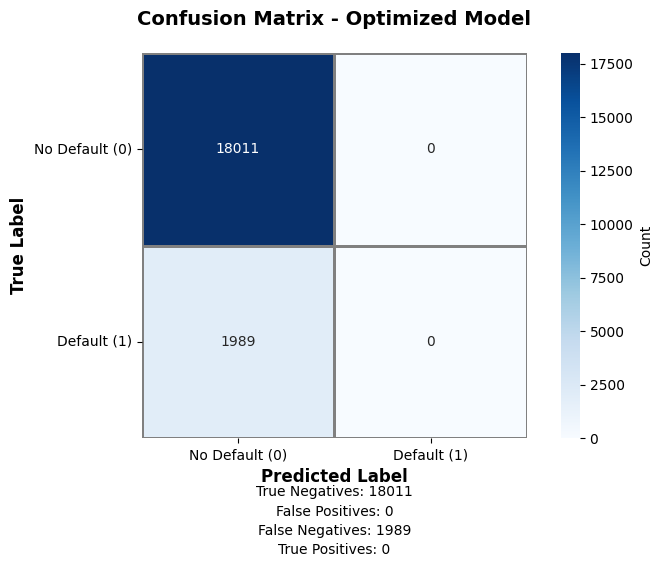


Model Metrics:
Accuracy:  0.9005 (90.05%)
Precision: 0.0000 (0.00%)
Recall:    0.0000 (0.00%)
F1-Score:  0.0000 (0.00%)


In [ ]:
plot_confusion_matrix(y_test, y_pred_baseline, cmap="Blues")

In [30]:
# Feature importance (if model supports it)
if hasattr(model_baseline, "feature_importances_"):
    feature_names = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame(
        {"feature": feature_names, "importance": model_baseline.feature_importances_}
    ).sort_values("importance", ascending=False)

    print("\nTop 10 Most Important Features:")
    print(importance_df.head(10))

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df.head(15)["feature"], importance_df.head(15)["importance"])
    plt.xlabel("Importance")
    plt.title("Top 15 Feature Importances")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
elif hasattr(model_baseline, "coef_"):
    feature_names = preprocessor.get_feature_names_out()
    importance_df = pd.DataFrame(
        {"feature": feature_names, "coefficient": np.abs(model_baseline.coef_[0])}
    ).sort_values("coefficient", ascending=False)

    print("\nTop 10 Most Important Features (by coefficient magnitude):")
    print(importance_df.head(10))


In [31]:
# Cross-validation score
cv_scores = cross_val_score(
    model_baseline, preprocessed_train_data, y_train, cv=5, scoring="f1"
)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Cross-validation F1 scores: [0. 0. 0. 0. 0.]
Mean CV F1: 0.0000 (+/- 0.0000)


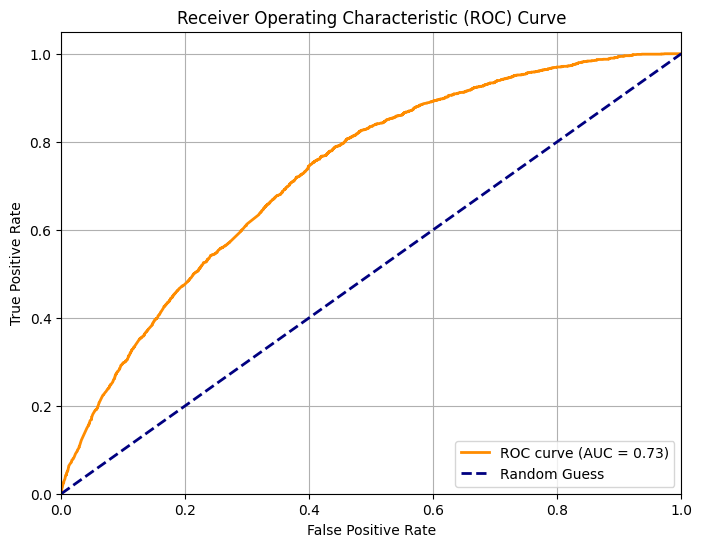

In [32]:
# Plot ROC curve for baseline model
plot_roc_curve(y_test, y_pred_proba_baseline)


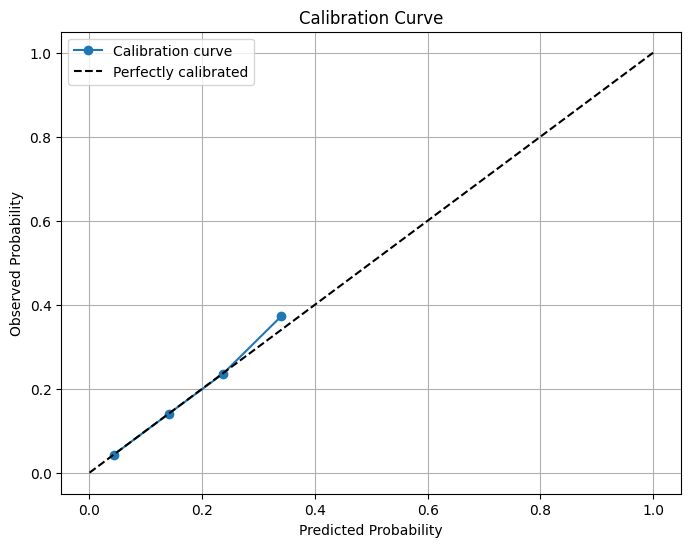

In [33]:
plot_calibration_curve(y_test, y_pred_proba_baseline)

## Hyperparameter fine-tuning (Optuna)

In [34]:
cv_splits = 5
n_trials = 200

In [35]:
def objective(trial):
    """
    Optuna objective function for hyperparameter optimization with CV.
    Adapt the hyperparameters based on your model.
    """

    # Suggest hyperparameters
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 15, 255),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 5, 100),
        "l2_regularization": trial.suggest_float("l2_regularization", 0, 10),
        "max_bins": trial.suggest_categorical("max_bins", [128, 255]),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"]),
    }

    # Create model with suggested hyperparameters
    model = HistGradientBoostingClassifier(**params)

    # Use cross-validation on TRAINING data only (more robust than single split)
    cv_scores = cross_val_score(
        model,
        preprocessed_train_data,
        y_train,
        cv=cv_splits,
        scoring="f1",
        n_jobs=-1,
    )

    # Return mean CV score
    return cv_scores.mean()


# Create and run the study
study = optuna.create_study(direction="maximize")  # Maximize F1-score
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

print("\n" + "=" * 60)
print("BEST HYPERPARAMETERS")
print("=" * 60)
print(f"Best CV F1-Score: {study.best_value:.4f}")
print(f"\nBest Parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2025-10-25 19:05:49,151] A new study created in memory with name: no-name-c531de87-75fe-4da4-8822-2ed6e7537709


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-25 19:05:50,730] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 0.028100789695017135, 'max_iter': 245, 'max_depth': 3, 'max_leaf_nodes': 20, 'min_samples_leaf': 51, 'l2_regularization': 7.301841420747957, 'max_bins': 255, 'class_weight': None}. Best is trial 0 with value: 0.0.
[I 2025-10-25 19:05:53,308] Trial 1 finished with value: 0.2760283201657681 and parameters: {'learning_rate': 0.015983242091599095, 'max_iter': 343, 'max_depth': 7, 'max_leaf_nodes': 138, 'min_samples_leaf': 45, 'l2_regularization': 6.209677038093754, 'max_bins': 255, 'class_weight': 'balanced'}. Best is trial 1 with value: 0.2760283201657681.
[I 2025-10-25 19:05:54,443] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.05855559673620893, 'max_iter': 541, 'max_depth': 8, 'max_leaf_nodes': 141, 'min_samples_leaf': 5, 'l2_regularization': 4.631196636145925, 'max_bins': 128, 'class_weight': None}. Best is trial 1 with value: 0.2760283201657681.
[I 2025-10-25 19:05:55

In [36]:
# Train the final model with best parameters on full training set
best_params = study.best_params.copy()

model_optimized = HistGradientBoostingClassifier(**best_params, random_state=42)

model_optimized.fit(preprocessed_train_data, y_train)

# Make predictions on test set
y_pred_proba_optimized = model_optimized.predict_proba(preprocessed_test_data)[:, 1]

# Find optimal threshold on test set
thresholds = np.arange(0.3, 0.7, 0.01)
f1_scores = [
    f1_score(y_test, (y_pred_proba_optimized >= t).astype(int)) for t in thresholds
]
optimal_threshold = thresholds[np.argmax(f1_scores)]

y_pred_optimized = (y_pred_proba_optimized >= optimal_threshold).astype(int)

print(f"Optimal threshold on test set: {optimal_threshold:.3f}")
print(f"Test F1-Score: {max(f1_scores):.4f}")


Optimal threshold on test set: 0.610
Test F1-Score: 0.2923


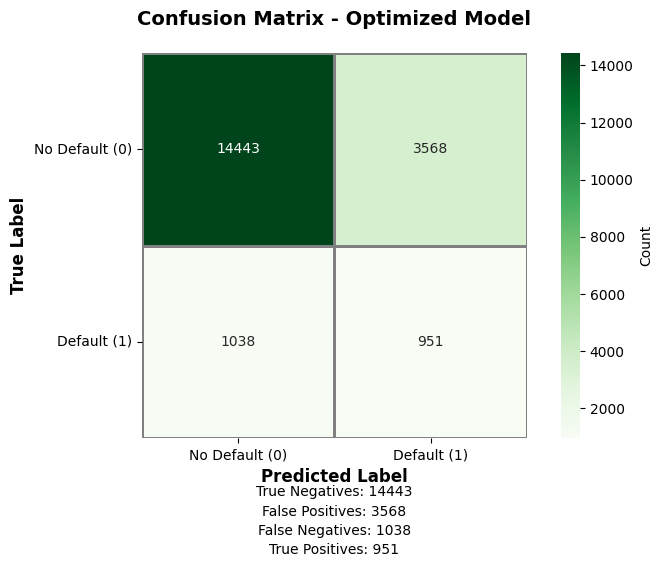


Model Metrics:
Accuracy:  0.7697 (76.97%)
Precision: 0.2104 (21.04%)
Recall:    0.4781 (47.81%)
F1-Score:  0.2923 (29.23%)


In [ ]:
plot_confusion_matrix(y_test, y_pred_optimized, cmap="Greens")

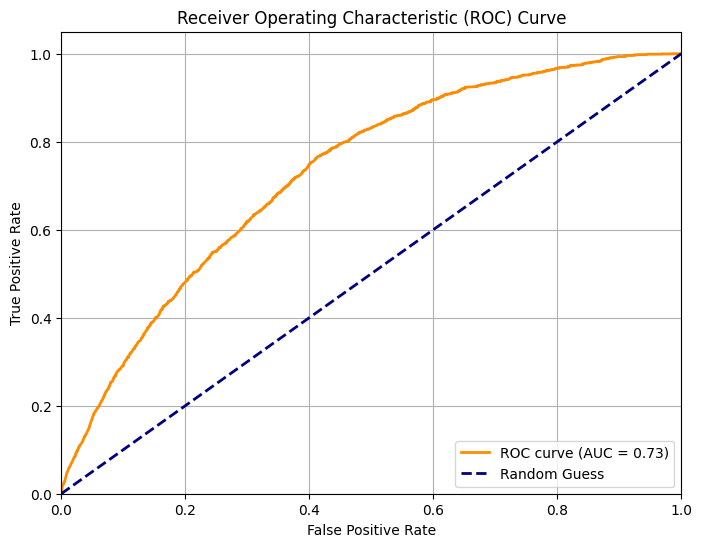

In [ ]:
# ROC curve for optimized model
plot_roc_curve(y_test, y_pred_proba_optimized)

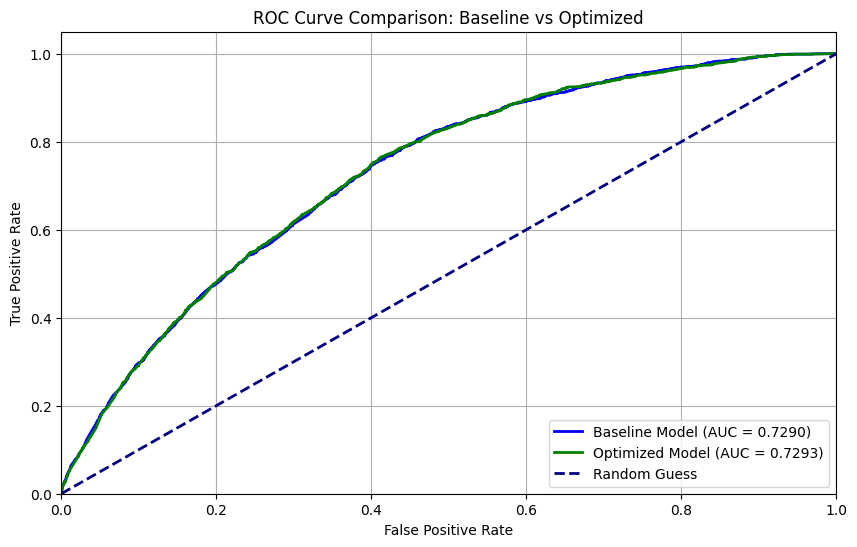

Baseline AUC: 0.7290
Optimized AUC: 0.7293
Improvement: 0.0003 (0.04%)


In [39]:
# Compare both models side by side


# Calculate ROC curves for both models
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
auc_baseline = roc_auc_score(y_test, y_pred_proba_baseline)

fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_pred_proba_optimized)
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)

# Plot both on the same figure
plt.figure(figsize=(10, 6))
plt.plot(
    fpr_baseline,
    tpr_baseline,
    color="blue",
    lw=2,
    label=f"Baseline Model (AUC = {auc_baseline:.4f})",
)
plt.plot(
    fpr_optimized,
    tpr_optimized,
    color="green",
    lw=2,
    label=f"Optimized Model (AUC = {auc_optimized:.4f})",
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Baseline vs Optimized")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Baseline AUC: {auc_baseline:.4f}")
print(f"Optimized AUC: {auc_optimized:.4f}")
print(
    f"Improvement: {auc_optimized - auc_baseline:.4f} ({((auc_optimized - auc_baseline) / auc_baseline * 100):.2f}%)"
)

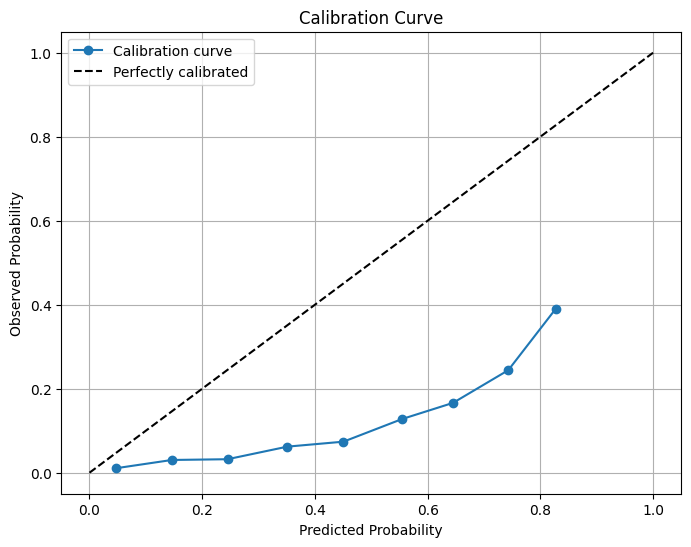

In [40]:
plot_calibration_curve(y_test, y_pred_proba_optimized)

In [41]:
# Calibrate the optimized model

model_calibrated = CalibratedClassifierCV(
    model_optimized, method="isotonic", cv="prefit"
)
model_calibrated.fit(preprocessed_train_data, y_train)

y_pred_proba_calibrated = model_calibrated.predict_proba(preprocessed_test_data)[:, 1]


# Find optimal threshold on test set
thresholds = np.arange(0, 1, 0.01)
f1_scores = [
    f1_score(y_test, (y_pred_proba_calibrated >= t).astype(int)) for t in thresholds
]
calibrated_threshold = thresholds[np.argmax(f1_scores)]

y_pred_calibrated = (y_pred_proba_calibrated >= calibrated_threshold).astype(int)

/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


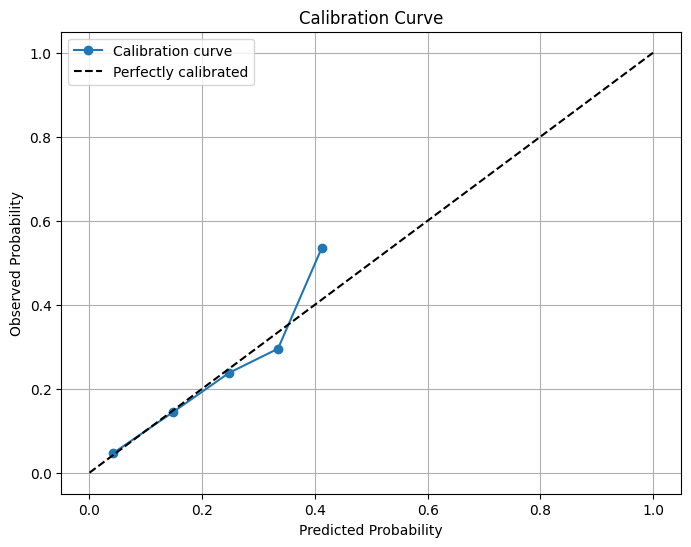

In [42]:
plot_calibration_curve(y_test, y_pred_proba_calibrated, n_bins=10)

In [43]:
compute_and_store_metrics(
    y_test, y_pred_optimized, model_name="HistGradientBoosting_Optimized"
)

compute_and_store_metrics(
    y_test, y_pred_calibrated, model_name="HistGradientBoosting_Calibrated"
)


In [44]:
# Final training on the entire dataset
# Preprocess full dataset
full_data = pd.concat([X, y], axis=1)
preprocessed_full_data, y_full, final_preprocessor = preprocess_data(
    full_data, fit=True
)

final_model = HistGradientBoostingClassifier(**best_params, random_state=42)

final_model.fit(preprocessed_full_data, y_full)

# Calibrate final model
model_calibrated_final = CalibratedClassifierCV(
    final_model, method="isotonic", cv="prefit"
)
model_calibrated_final.fit(preprocessed_full_data, y_full)

# Save both model and preprocessor
save_model(
    model_calibrated_final, model_name="HistGradientBoosting_Calibrated_Optimized"
)
save_model(
    final_preprocessor,
    model_name="HistGradientBoosting_Calibrated_Optimized_preprocessor",
)

print(f"✓ Model trained on full dataset ({len(y_full)} samples)")
print(f"✓ Model saved with calibrated threshold: {calibrated_threshold:.3f}")

2025-10-25 19:08:06.349 | INFO     | src.preprocessing:preprocess_data:62 - No preprocessor provided. Creating a new one.
2025-10-25 19:08:06.349 | INFO     | src.preprocessing:preprocess_data:67 - Applying log transformation to income
2025-10-25 19:08:06.353 | INFO     | src.preprocessing:preprocess_data:77 - Fitting and transforming data.
2025-10-25 19:08:06.405 | INFO     | src.utils.model_utils:save_model:39 - Model saved to: /home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/models/preprocessor.pkl
2025-10-25 19:08:06.405 | INFO     | src.preprocessing:preprocess_data:80 - Preprocessor fitted and saved.
/home/augustin/projects/xhec_dsb/05_intro_to_finance_for_data_scientists/.venv/lib64/python3.13/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
2025-10-25 19:08:06.648 | INFO     | src.utils

✓ Model trained on full dataset (100000 samples)
✓ Model saved with calibrated threshold: 0.150
